#MSM of the alanine dipeptide

First we import a number of libraries we will need as we run this example

In [20]:
%load_ext autoreload
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


###Discretizing the trajectory
We start loading the data using the data structures from the `trajectory` module. For this we use the external library [`MDtraj`](http://mdtraj.org), which contains all sorts of methods for parsing and calculating interestign properties of our time-series data.

In [15]:
import mdtraj as md
from mastermsm.trajectory import traj

In [16]:
tr = traj.TimeSeries(top='data/alaTB.gro', traj=['data/protein_only.xtc'])
print tr.mdt

<mdtraj.Trajectory with 10003 frames, 19 atoms, 3 residues, and unitcells>


So does what we have calculated look somewhat like a Ramachandran map?

In [18]:
phi = md.compute_phi(tr.mdt)
psi = md.compute_psi(tr.mdt)
res = [x for x in tr.mdt.topology.residues]

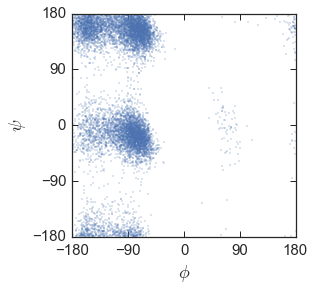

In [21]:
fig,ax = plt.subplots(figsize=(4,4))
ax.plot(180./math.pi*phi[1],180./math.pi*psi[1],'o', markersize=1)
ax.set_xlim(-180,180)
ax.set_ylim(-180,180)
ax.xaxis.set_ticks(range(-180,181,90))
ax.yaxis.set_ticks(range(-180,181,90))

ax.set_xlabel(r'$\phi$', fontsize=18)
ax.set_ylabel(r'$\psi$', fontsize=18)

Next we proceed to discretize the trajectory based on the Ramachandran angles.

In [22]:
tr.discretize(states=['A', 'E'])

For plotting we convert helical configurations in 1 and beta in 0.

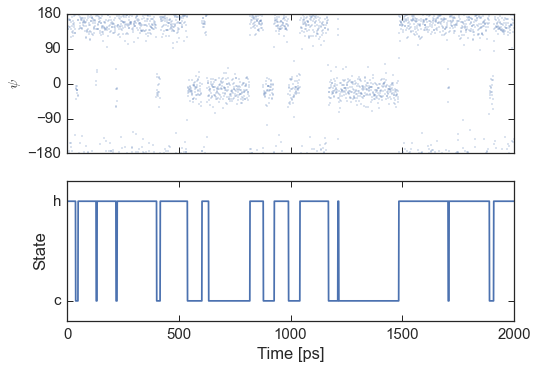

In [26]:
y = [0 if x == 'A' else 1 for x in tr.distraj]
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)
ax1.plot(psi[1]*180/math.pi,'o', markersize=1)
ax2.plot(y)

ax1.set_ylabel(r'$\psi$', fontsize=14)
ax1.set_xlim(0,2000)
ax1.set_ylim(-180,180)
ax1.yaxis.set_ticks(range(-180,181,90))

ax2.set_ylabel('State')
ax2.set_xlim(0,2000)
ax2.set_ylim(-0.2,1.2)
ax2.yaxis.set_ticks([0,1])
labels = [item.get_text() for item in ax2.get_xticklabels()]
labels[0] = 'c'
labels[1] = 'h'
ax2.set_yticklabels(labels)

ax2.set_xlabel('Time [ps]')


In the plot we see how we go from the time series of continuous torsion angles converts into a time series of discrete states. We can obtain a list of states in the following way.

In [27]:
tr.find_keys()
tr.keys
tr.file_name

['data/protein_only.xtc']

###Building the master equation model
After having load our trajectory using the functionalities from the `trajectory` module we start building the master equation model. For this, we make use of the `msm` module. We feed the same trajectory twice to check that functionality with more than one trajectory works alright.

In [28]:
from mastermsm.msm import msm
msm_alaTB = msm.SuperMSM([tr, tr])


 Building MSM from 
[['data/protein_only.xtc'], ['data/protein_only.xtc']]
     # states: 2


In [29]:
for i in [1, 2, 5, 10, 20, 50]:
    msm_alaTB.do_msm(i)

We first construct the MSM at multiple lag times, to see at which point the relaxation times are sufficiently well converged.

In [53]:
msm_alaTB.convergence_test(time=[1, 2, 5, 10, 20, 50, 100, 200], error=True)

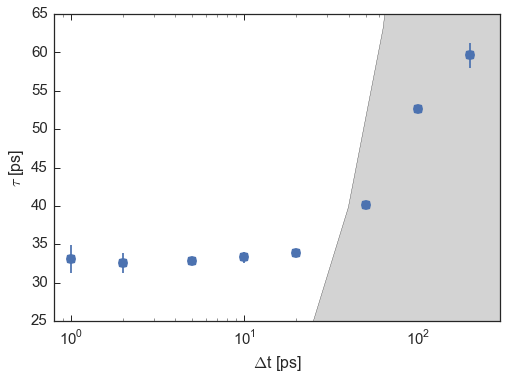

In [70]:
tau_vs_lagt = np.array([[x,msm_alaTB.msms[x].tauT[0],msm_alaTB.msms[x].tau_std[0]] \
               for x in sorted(msm_alaTB.msms.keys())])
fig, ax = plt.subplots()
ax.errorbar(tau_vs_lagt[:,0],tau_vs_lagt[:,1],fmt='o', yerr=tau_vs_lagt[:,2], markersize=10)
#ax.plot(tau_vs_lagt[:,0],tau_vs_lagt[:,0])
ax.fill_between(10**np.arange(-0.2,3,0.2), 1e-1, 10**np.arange(-0.2,3,0.2), facecolor='lightgray')
ax.set_xlabel(r'$\Delta$t [ps]', fontsize=16)
ax.set_ylabel(r'$\tau$ [ps]', fontsize=16)
ax.set_xlim(0.8,300)
ax.set_ylim(25,65)
_ = ax.set_xscale('log')
#ax.set_yscale('log')


Here we see that from the very beginning the relaxation times are independent of the lag time ($\Delta$t) used in the construction of the model. This convergence is a good indicator of the Markovianity of the model and is a result of the use of transition based assignment. The shaded area corresponds to the range of lag times where the information we obtain is largely unreliable as the lag time is larger than the transition time.

###Calculation of the rate matrix
From the transition matrix we can calculate the rate matrix. One possibility is to use an approximate method based simply on a Taylor expansion. We can check whether our approximate method gives a good result.

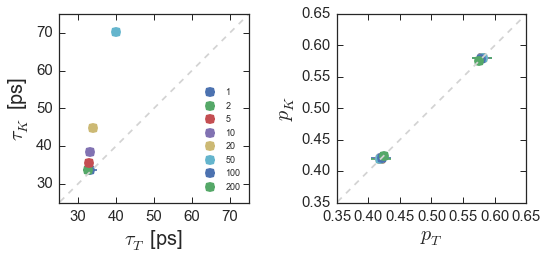

In [111]:
fig, ax = plt.subplots(1,2, figsize=(7.5,3.5))
for i in [1, 2, 5, 10, 20, 50, 100, 200]:
    msm_alaTB.msms[i].do_rate()
    ax[0].errorbar(msm_alaTB.msms[i].tauT, msm_alaTB.msms[i].tauK, fmt='o', xerr=msm_alaTB.msms[i].tau_std, markersize=10, label=str(i))
    ax[1].errorbar(msm_alaTB.msms[i].peqT, msm_alaTB.msms[i].peqK, fmt='o', xerr=msm_alaTB.msms[i].peq_std, markersize=10, label=str(i))

ax[0].plot([0,100],[0,100],'--', color='lightgray')
ax[0].set_xlabel(r'$\tau_T$ [ps]', fontsize=20)
ax[0].set_ylabel(r'$\tau_K$ [ps]', fontsize=20)
ax[0].set_xlim(25,75)
ax[0].set_ylim(25,75)

ax[1].plot([0.1,1],[0.1,1],'--', color='lightgray')
#ax[1].set_xscale('log')
#ax[1].set_yscale('log')
ax[1].set_xlabel(r'$p_T$', fontsize=20)
ax[1].set_ylabel(r'$p_K$', fontsize=20)
ax[1].set_xlim(0.35,0.65)
ax[1].set_ylim(0.35,0.65)

ax[0].legend(fontsize=9, bbox_to_anchor=(1.0, 0.65))
plt.tight_layout(pad=0.4, w_pad=3)

Clearly, for lag times up to 10 ps the approximation is reasonable for the relaxation times, and it is good at all lag times for the equilibrium probabilities.